In [2]:
#Use 13-long gene-diffmat corr to predict symptoms 
#Plot beta-weights (use 13 corr with cmat as control) 
#See symptoms prediction accuracy (diff > cmat)

In [229]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [3]:
cd ../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [4]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [5]:
df.shape

(699, 36)

In [6]:
#load in diffmat data
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [7]:
atlas = ants.image_read('../../YeoAtlas/Atlas_parc-7n_2mm.nii')

In [8]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [9]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
13


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


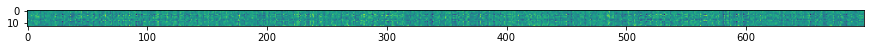

In [11]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)

In [253]:
#change here for each column
col_id = 0

In [254]:
#remove nans
Y = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id]) #column selected
print(column)
good_subjects = ~np.isnan(Y)[:,col_id]

ados_total


In [255]:
#separate non-nan subjects in selected column
Y_use = Y[good_subjects,col_id] 
Y_use.shape

(429,)

In [256]:
gene_fmri_corr.shape

(13, 699)

In [257]:
#match non-nan subjects in gene_fmri_corr
X_use = gene_fmri_corr[:,good_subjects]
X_use = X_use.transpose() #match column row size with Y_use
X_use.shape

(429, 13)

In [258]:
#perform multivariate linear regression
regression =  linear_model.LinearRegression(normalize=True)
linear_regression = regression.fit(X_use,Y_use) 

In [259]:
X_use.shape # Stuff we use to predict

(429, 13)

In [260]:
Y_use.shape # Stuff we want to predict

(429,)

In [261]:
Y_use_hat = linear_regression.predict(X_use)

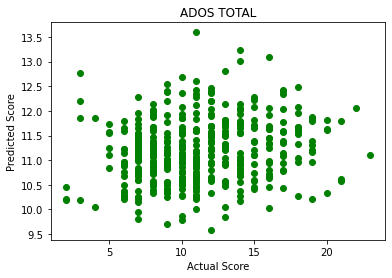

In [185]:
#scatter plot for ados_total
plt.scatter(Y_use,Y_use_hat,color='green')
plt.title('ADOS TOTAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

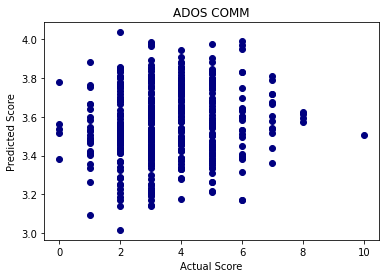

In [195]:
#scatter plot for ados_comm
plt.scatter(Y_use,Y_use_hat,color='navy')
plt.title('ADOS COMM')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

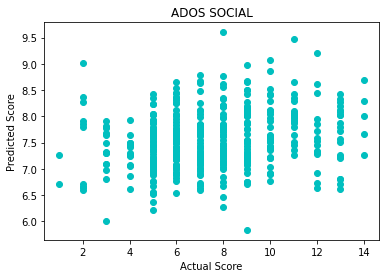

In [206]:
#scatter plot for ados_social
plt.scatter(Y_use,Y_use_hat,color='c')
plt.title('ADOS SOCIAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

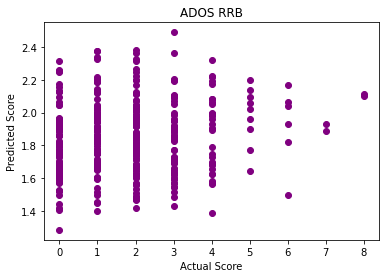

In [217]:
#scatter plot for ados_rrb
plt.scatter(Y_use,Y_use_hat,color='purple')
plt.title('ADOS RRB')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [166]:
#variance explained for ados_total
from sklearn.metrics import explained_variance_score
total = explained_variance_score(Y_use,Y_use_hat)*100
print(total)

2.651116934212927


In [156]:
#variance explained for ados_comm
from sklearn.metrics import explained_variance_score
comm = explained_variance_score(Y_use,Y_use_hat)*100
print(comm)

1.369006035359288


In [146]:
#variance explained for ados_social
from sklearn.metrics import explained_variance_score
social = explained_variance_score(Y_use,Y_use_hat)*100
print(social)

4.331740939194462


In [134]:
#variance explained for ados_rrb
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use,Y_use_hat)*100
print(rrb)

2.0557265540216085


Text(0.5, 0, 'Symptom')

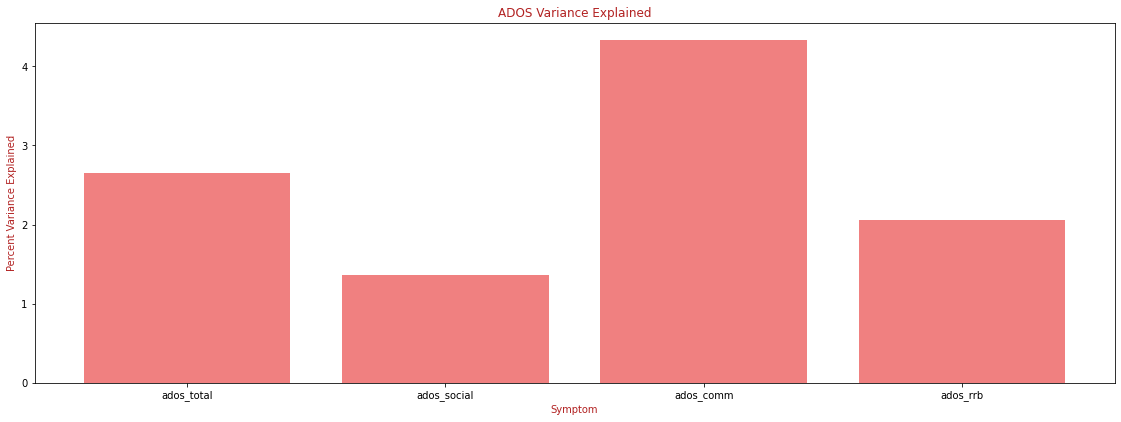

In [219]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ados_total','ados_social','ados_comm','ados_rrb']
var_explained = total, comm, social, rrb
plt.bar(ados_label,var_explained,color='lightcoral')
plt.title('ADOS Variance Explained',color='firebrick')
plt.ylabel('Percent Variance Explained',color='firebrick')
plt.xlabel('Symptom',color='firebrick')

In [175]:
#correlation coefficents for ados_total
coefficient = regression.coef_
labels = ['NLGN4Y', 'POGZ', 'FMR1', 'CNTNAP2', 'NLGN3','NLGN4X', 'MECP2', 'MET', 'OXTR', 'RELN','SHANK3', 'SLC6A4', 'NRXN1']
print(column)
print()
for i in range(0,13):
    print(f'{labels[i]},{coefficient[i]}')

ados_total

NLGN4Y,-12.162957127918375
POGZ,-4.388783843158301
FMR1,5.690059081352753
CNTNAP2,4.4417833940699545
NLGN3,-3.2014188909157144
NLGN4X,-1.6916949878879142
MECP2,4.002212381346231
MET,0.7904133923030469
OXTR,2.32897755697988
RELN,4.409249520973453
SHANK3,1.282086436105105
SLC6A4,3.610673945733059
NRXN1,-2.366335969493219


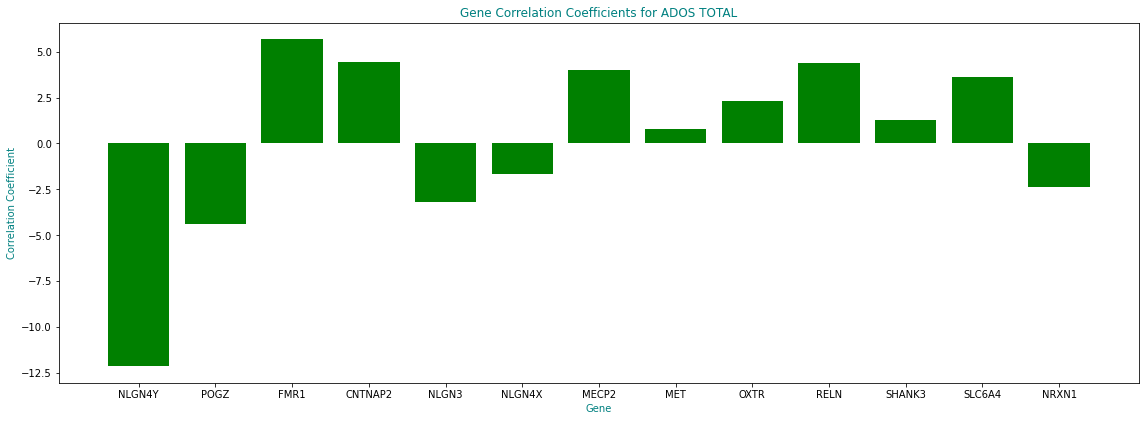

In [178]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient,color='green')
plt.title('Gene Correlation Coefficients for ADOS TOTAL',color='teal')
plt.ylabel('Correlation Coefficient',color='teal')
plt.xlabel('Gene',color='teal')
plt.show()

In [161]:
#correlation coefficents for ados_comm
coefficient = regression.coef_
labels = ['NLGN4Y', 'POGZ', 'FMR1', 'CNTNAP2', 'NLGN3','NLGN4X', 'MECP2', 'MET', 'OXTR', 'RELN','SHANK3', 'SLC6A4', 'NRXN1']
print(column)
print()
for i in range(0,13):
    print(f'{labels[i]},{coefficient[i]}')

ados_comm

NLGN4Y,-1.0459985398891152
POGZ,0.4416499274701452
FMR1,0.8676739276128245
CNTNAP2,-0.03576914448953731
NLGN3,-0.02514412607104068
NLGN4X,1.9137141436651965
MECP2,-0.21080521919493042
MET,0.41651689879626635
OXTR,0.8377970017771396
RELN,0.7388025614186521
SHANK3,-1.934773715552239
SLC6A4,1.085506048225736
NRXN1,-0.3489912999635063


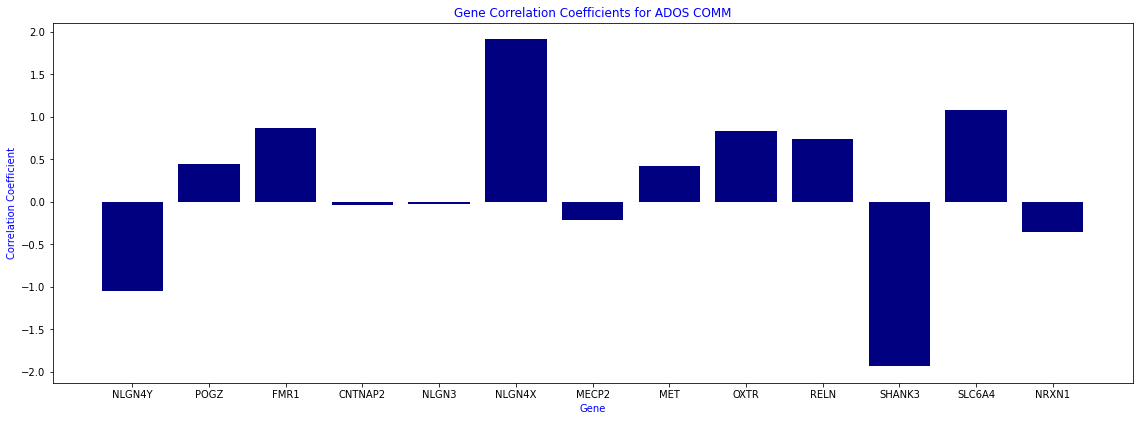

In [165]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient,color='navy')
plt.title('Gene Correlation Coefficients for ADOS COMM',color='b')
plt.ylabel('Correlation Coefficient',color='b')
plt.xlabel('Gene',color='b')
plt.show()

In [145]:
#correlation coefficents for ados_social
coefficient = regression.coef_
labels = ['NLGN4Y', 'POGZ', 'FMR1', 'CNTNAP2', 'NLGN3','NLGN4X', 'MECP2', 'MET', 'OXTR', 'RELN','SHANK3', 'SLC6A4', 'NRXN1']
print(column)
print()
for i in range(0,13):
    print(f'{labels[i]},{coefficient[i]}')

ados_social

NLGN4Y,-10.19251810368778
POGZ,-4.108129804137099
FMR1,5.1762636158632365
CNTNAP2,3.509348071857971
NLGN3,-3.0533951817935483
NLGN4X,-3.6540614773203832
MECP2,3.63208463744494
MET,0.46627934915220276
OXTR,2.0933506053947615
RELN,4.2237793382214806
SHANK3,1.5632638471674585
SLC6A4,3.6362813304514314
NRXN1,-1.9123520034052086


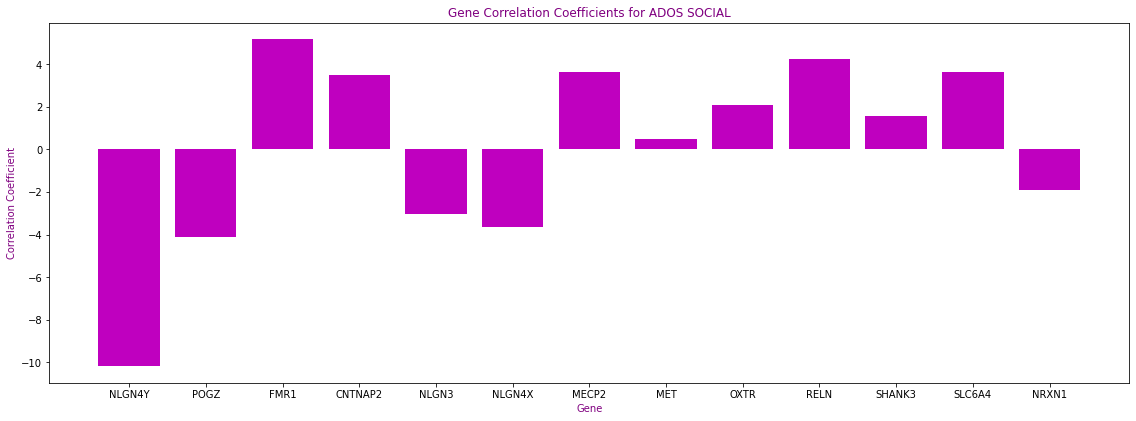

In [151]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient,color='m')
plt.title('Gene Correlation Coefficients for ADOS SOCIAL',color='purple')
plt.ylabel('Correlation Coefficient',color='purple')
plt.xlabel('Gene',color='purple')
plt.show()

In [221]:
#correlation coefficents for ados_rrb
coefficient = regression.coef_
labels = ['NLGN4Y', 'POGZ', 'FMR1', 'CNTNAP2', 'NLGN3','NLGN4X', 'MECP2', 'MET', 'OXTR', 'RELN','SHANK3', 'SLC6A4', 'NRXN1']
print(column)
print()
for i in range(0,13):
    print(f'{labels[i]},{coefficient[i]}')

ados_rrb

NLGN4Y,-2.8869322783922113
POGZ,-2.847030619933946
FMR1,0.07752391434545994
CNTNAP2,0.3074055365213848
NLGN3,0.3232231403622317
NLGN4X,1.9006615653931531
MECP2,-1.163695193892065
MET,-1.2176954053367899
OXTR,0.7053037542222543
RELN,-0.5651829277978802
SHANK3,1.8234551122836002
SLC6A4,-0.5520593823887985
NRXN1,1.3601295030463723


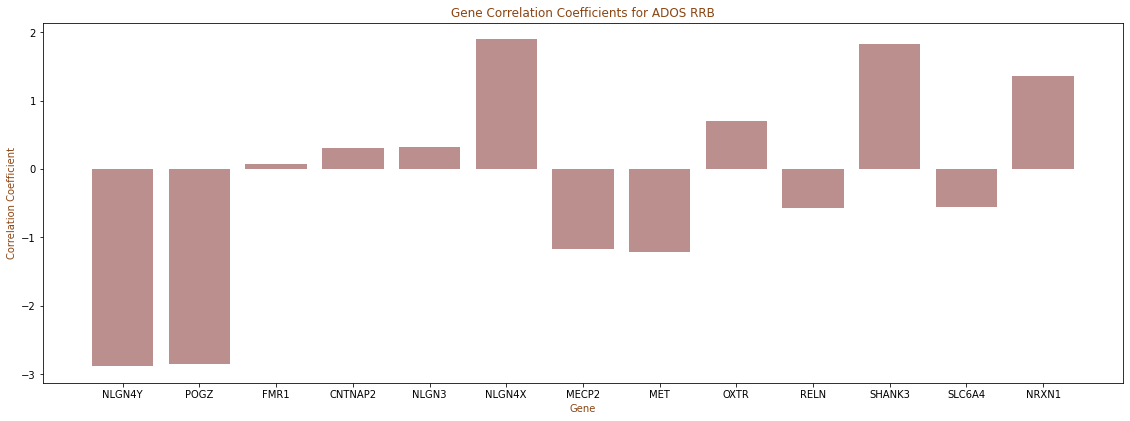

In [227]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient,color='rosybrown')
plt.title('Gene Correlation Coefficients for ADOS RRB',color='saddlebrown')
plt.ylabel('Correlation Coefficient',color='saddlebrown')
plt.xlabel('Gene',color='saddlebrown')
plt.show()

In [262]:
#significance of coefficients for ados_total
print('ADOS_TOTAL')
X2 = sm.add_constant(Y_use)
est = sm.OLS(Y_use_hat, X2)
est2 = est.fit()
print(est2.summary())

ADOS_TOTAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     11.63
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           0.000711
Time:                        15:32:55   Log-Likelihood:                -405.35
No. Observations:                 429   AIC:                             814.7
Df Residuals:                     427   BIC:                             822.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9103      0.092    118.3

In [252]:
#significance of coefficients for ados_comm
print('ADOS_COMM')
X2 = sm.add_constant(Y_use)
est = sm.OLS(Y_use_hat, X2)
est2 = est.fit()
print(est2.summary())

ADOS_COMM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.677
Date:                Sat, 15 Oct 2022   Prob (F-statistic):             0.0176
Time:                        15:32:28   Log-Likelihood:                 110.04
No. Observations:                 411   AIC:                            -216.1
Df Residuals:                     409   BIC:                            -208.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5109      0.022    156.68

In [242]:
#significance of coefficients for ados_social
print('ADOS_SOCIAL')
X2 = sm.add_constant(Y_use)
est = sm.OLS(Y_use_hat, X2)
est2 = est.fit()
print(est2.summary())

ADOS_SOCIAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     18.56
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           2.06e-05
Time:                        15:31:54   Log-Likelihood:                -342.47
No. Observations:                 412   AIC:                             688.9
Df Residuals:                     410   BIC:                             697.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2425      0.081     89.

In [232]:
#significance of coefficients for ados_rrb
print('ADOS_RRB')
X2 = sm.add_constant(Y_use)
est = sm.OLS(Y_use_hat, X2)
est2 = est.fit()
print(est2.summary())

ADOS_RRB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     7.829
Date:                Sat, 15 Oct 2022   Prob (F-statistic):            0.00541
Time:                        15:30:59   Log-Likelihood:                 40.990
No. Observations:                 375   AIC:                            -77.98
Df Residuals:                     373   BIC:                            -70.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8100      0.018    102.720